# Primeiros Passos - Análise de Sentimentos com Naive Bayes

Análise de sentimentos de sentenças financeiras utilizando Naive Bayes. Procedimentos realizados:

1. Aplicação do modelo de machine learning Naive Bayes para análise de sentimentos de sentenças financeiras em inglês
2. Processamento de texto - aplicação do framework para limpeza e tratamento de texto
3. Aplicação do modelo à sentenças financeiras em pt-br
4. Processamento de texto aos dados brasileiros

## Carregando pacotes

In [1]:
# !python -m spacy download en_core_web_sm

# Tratamento e visualização de dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Processamento de linguagem natural/texto
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import ToktokTokenizer
from nltk.stem import PorterStemmer
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Algoritmos de Machine Learning
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\luans\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Leitura e análise de dados

In [3]:
# Lendo o conjunto de dados
df = pd.read_csv('dados/financial_sentences.csv')
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [4]:
df['Sentiment'].value_counts()

Sentiment
neutral     3130
positive    1852
negative     860
Name: count, dtype: int64

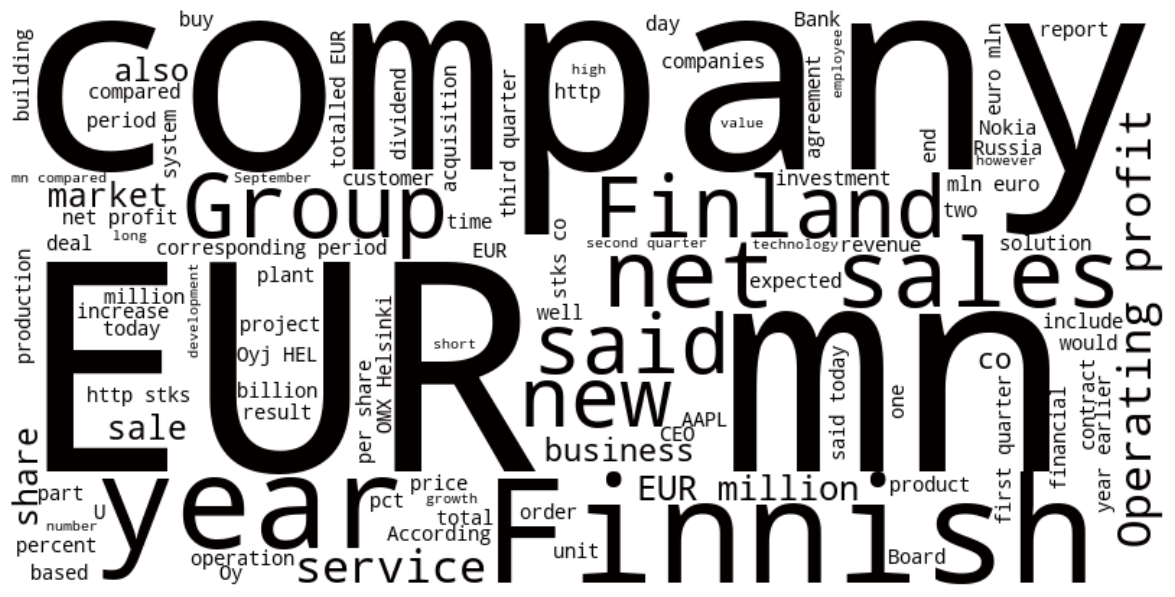

In [6]:
# WORDCLOUD
from wordcloud import WordCloud

def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")

text = ' '.join(word for word in df['Sentence'])
wordcloud = WordCloud(max_words=100, stopwords=stopwords.words('english'), background_color='white', width=800, height=400).generate(text)
wordcloud.recolor(color_func=black_color_func)
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

wordcloud.to_file('imagens/financial_phrases_wordcloud.png')

## Aplicação do Modelo Naive Bayes sem transformação e limpeza dos dados

In [7]:
# Semente aleatória para reprodutibilidade
np.random.seed(2360873)

In [8]:
x = df['Sentence']
y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model = make_pipeline(CountVectorizer(), MultinomialNB())
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.45      0.31      0.37       175
     neutral       0.74      0.86      0.79       622
    positive       0.74      0.65      0.70       372

    accuracy                           0.71      1169
   macro avg       0.65      0.61      0.62      1169
weighted avg       0.70      0.71      0.70      1169



In [9]:
# Calcular métricas
acc_grid = accuracy_score(y_test, y_pred)
prec_grid = precision_score(y_test, y_pred, average='weighted')
rec_grid = recall_score(y_test, y_pred, average='weighted')
f1_grid = f1_score(y_test, y_pred, average='weighted')

print("=" * 60)
print("RESULTADOS DO MODELO NAIVE BAYES")
print("=" * 60)
print(f"Accuracy:  {acc_grid:2.2%}")
print(f"Precision: {prec_grid:2.2%}")
print(f"Recall:    {rec_grid:2.2%}")
print(f"F1 Score:  {f1_grid:2.2%}")
print("=" * 60)

RESULTADOS DO MODELO NAIVE BAYES
Accuracy:  71.09%
Precision: 69.79%
Recall:    71.09%
F1 Score:  69.92%


Confusion matrix, without normalization
[[ 55  75  45]
 [ 50 533  39]
 [ 16 113 243]]
Normalized confusion matrix
[[0.31428571 0.42857143 0.25714286]
 [0.08038585 0.85691318 0.06270096]
 [0.04301075 0.30376344 0.65322581]]


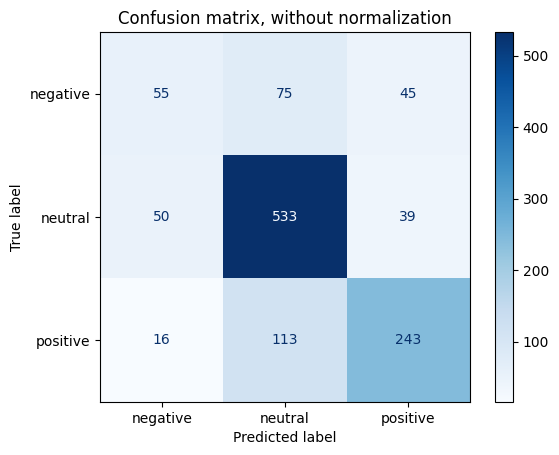

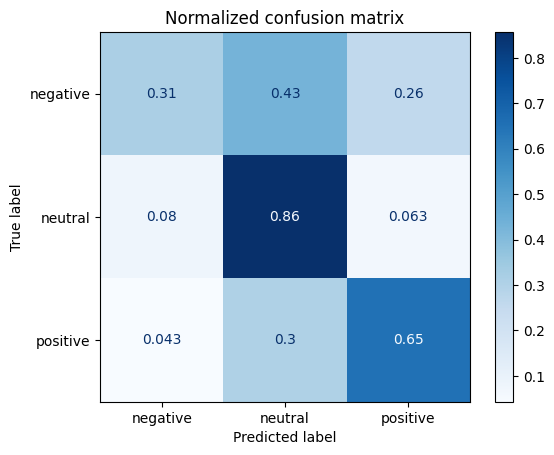

In [10]:
# Fonte: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        display_labels=['negative', 'neutral', 'positive'],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

## Otimização do Modelo Naive Bayes

### Ajuste de Hiperparâmetros com GridSearchCV

GridSearchCV é uma técnica que testa automaticamente diferentes combinações de hiperparâmetros para encontrar a melhor configuração.

### Por que isso funciona?
- **max_features**: Limita o vocabulário. Menos features = menos ruído, mais features = mais contexto
- **ngram_range**: (1,1) = palavras individuais, (1,2) = palavras individuais + pares de palavras (bigrams)
- **alpha (Laplace smoothing)**: Controla a suavização. Valores menores = confiança maior nos dados

### Como funciona?
O GridSearchCV testa TODAS as combinações possíveis e valida cada uma usando k-fold cross-validation (padrão: 5 folds). Ele retorna a melhor combinação com base na métrica escolhida (F1 ponderado).

In [11]:
param_grid = {
    'countvectorizer__max_features': [1000, 2000, 5000],
    'countvectorizer__ngram_range': [(1, 1), (1, 2)],
    'multinomialnb__alpha': [0.01, 0.1, 1.0]
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_weighted')
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.4f}")

Best parameters: {'countvectorizer__max_features': 5000, 'countvectorizer__ngram_range': (1, 2), 'multinomialnb__alpha': 1.0}
Best CV score: 0.6981


In [12]:
y_pred_grid = grid_search.predict(X_test)

print(classification_report(y_test, y_pred_grid))

              precision    recall  f1-score   support

    negative       0.43      0.45      0.44       175
     neutral       0.80      0.80      0.80       622
    positive       0.72      0.71      0.72       372

    accuracy                           0.72      1169
   macro avg       0.65      0.65      0.65      1169
weighted avg       0.72      0.72      0.72      1169



In [13]:
# Calcular métricas
acc_grid = accuracy_score(y_test, y_pred_grid)
prec_grid = precision_score(y_test, y_pred_grid, average='weighted')
rec_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_grid = f1_score(y_test, y_pred_grid, average='weighted')

print("=" * 60)
print("RESULTADOS DO MODELO OTIMIZADO COM GRIDSEARCHCV")
print("=" * 60)
print(f"Accuracy:  {acc_grid:2.2%}")
print(f"Precision: {prec_grid:2.2%}")
print(f"Recall:    {rec_grid:2.2%}")
print(f"F1 Score:  {f1_grid:2.2%}")
print("=" * 60)

RESULTADOS DO MODELO OTIMIZADO COM GRIDSEARCHCV
Accuracy:  71.86%
Precision: 72.02%
Recall:    71.86%
F1 Score:  71.93%


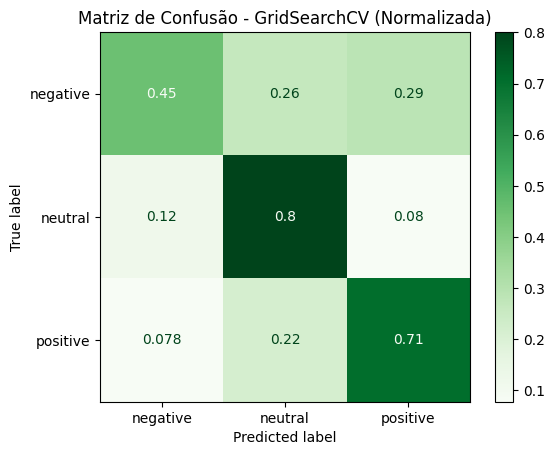

In [21]:
disp = ConfusionMatrixDisplay.from_estimator(
    grid_search,
    X_test,
    y_test,
    display_labels=['negative', 'neutral', 'positive'],
    cmap=plt.cm.Greens,
    normalize='true'
)
disp.ax_.set_title("Matriz de Confusão - GridSearchCV (Normalizada)")
plt.show()

In [14]:
# salvando modelo com melhores parâmetros

import joblib
joblib.dump(grid_search.best_estimator_, 'modelos/naive_bayes_sentiment_analysis.pkl')

['modelos/naive_bayes_sentiment_analysis.pkl']

## Pré-processamento dos dados

Aplicar as etapas de pré-processamento aos dados para melhoria do modelo  
1- Lowercasing  
2- Remoção de pontuação  
3- Tokenização  
4- Remoção de stopwords  
5- Stemming  
6- Lemmatization  

In [29]:
# Lowercasing

df['Sentence_clear'] = df['Sentence'].str.lower()
df.head()

,Sentence,Sentiment,Sentence_clear
0,The GeoSolutions technology will leverage Bene...,positive,the geosolutions technology will leverage bene...
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,"$esi on lows, down $1.50 to $2.50 bk a real po..."
2,"For the last quarter of 2010 , Componenta 's n...",positive,"for the last quarter of 2010 , componenta 's n..."
3,According to the Finnish-Russian Chamber of Co...,neutral,according to the finnish-russian chamber of co...
4,The Swedish buyout firm has sold its remaining...,neutral,the swedish buyout firm has sold its remaining...


In [30]:
# Remoção de pontuação

import string

df['Sentence_clear'] = df['Sentence_clear'].str.translate(str.maketrans('', '', string.punctuation))

df.head() 

,Sentence,Sentiment,Sentence_clear
0,The GeoSolutions technology will leverage Bene...,positive,the geosolutions technology will leverage bene...
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,esi on lows down 150 to 250 bk a real possibility
2,"For the last quarter of 2010 , Componenta 's n...",positive,for the last quarter of 2010 componenta s net...
3,According to the Finnish-Russian Chamber of Co...,neutral,according to the finnishrussian chamber of com...
4,The Swedish buyout firm has sold its remaining...,neutral,the swedish buyout firm has sold its remaining...


In [33]:
# Remoção de stopwords

tokenizer = ToktokTokenizer()
stopwords = set(stopwords.words('english'))

df['Sentence_clear'] = df['Sentence_clear'].apply(lambda x: ' '.join([word for word in tokenizer.tokenize(x) if word not in stopwords]))

df.head()

,Sentence,Sentiment,Sentence_clear
0,The GeoSolutions technology will leverage Bene...,positive,geosolutions technology leverage benefon gps s...
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,esi lows 150 250 bk real possibility
2,"For the last quarter of 2010 , Componenta 's n...",positive,last quarter 2010 componenta net sales doubled...
3,According to the Finnish-Russian Chamber of Co...,neutral,according finnishrussian chamber commerce majo...
4,The Swedish buyout firm has sold its remaining...,neutral,swedish buyout firm sold remaining 224 percent...


In [15]:
# Stemming

# ps = PorterStemmer()

# data['Sentence_clear'] = data['Sentence_clear'].apply(lambda x: ' '.join([ps.stem(word) for word in x.split()]))

# data.head()

In [34]:
# Lemmatization

lemma_docs = nlp.pipe(df['Sentence_clear'].astype(str))

df['Sentence_clear'] = [' '.join([token.lemma_ for token in doc]) for doc in lemma_docs]

df.head()

,Sentence,Sentiment,Sentence_clear
0,The GeoSolutions technology will leverage Bene...,positive,geosolution technology leverage benefon gps so...
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,esi low 150 250 bk real possibility
2,"For the last quarter of 2010 , Componenta 's n...",positive,last quarter 2010 componenta net sale double e...
3,According to the Finnish-Russian Chamber of Co...,neutral,accord finnishrussian chamber commerce major c...
4,The Swedish buyout firm has sold its remaining...,neutral,swedish buyout firm sell remain 224 percent st...


In [35]:
df.to_csv('financial_sentences_cleaned.csv', index=False)

## Aplicando Modelo Naive Bayes aos dados tratados

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df['Sentence_clear'], df['Sentiment'], test_size=0.2, random_state=42)

model_2 = make_pipeline(CountVectorizer(), MultinomialNB())
model_2.fit(X_train, y_train)

y_pred = model_2.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.40      0.33      0.36       175
     neutral       0.75      0.83      0.78       622
    positive       0.72      0.65      0.68       372

    accuracy                           0.70      1169
   macro avg       0.62      0.60      0.61      1169
weighted avg       0.69      0.70      0.69      1169



In [18]:
grid_search_2 = GridSearchCV(model, param_grid, cv=5, scoring='f1_weighted')
grid_search_2.fit(X_train, y_train)

print(f"Best parameters: {grid_search_2.best_params_}")
print(f"Best CV score: {grid_search_2.best_score_:.4f}")

Best parameters: {'countvectorizer__max_features': 5000, 'countvectorizer__ngram_range': (1, 2), 'multinomialnb__alpha': 1.0}
Best CV score: 0.6824


In [23]:
y_pred_gs = grid_search_2.predict(X_test)

print(classification_report(y_test, y_pred_gs))

              precision    recall  f1-score   support

    negative       0.42      0.43      0.43       175
     neutral       0.78      0.78      0.78       622
    positive       0.70      0.69      0.70       372

    accuracy                           0.70      1169
   macro avg       0.63      0.64      0.63      1169
weighted avg       0.70      0.70      0.70      1169



In [24]:
acc_grid_2 = accuracy_score(y_test, y_pred_gs)
prec_grid_2 = precision_score(y_test, y_pred_gs, average='weighted')
rec_grid_2 = recall_score(y_test, y_pred_gs, average='weighted')
f1_grid_2 = f1_score(y_test, y_pred_gs, average='weighted')

print("=========COMPARATIVO DE MODELOS=========")

print("=" * 60)
print("RESULTADOS DO MODELO NB OTIMIZADO COM GRIDSEARCHCV")
print("=" * 60)
print(f"Accuracy:  {acc_grid:2.2%}")
print(f"Precision: {prec_grid:2.2%}")
print(f"Recall:    {rec_grid:2.2%}")
print(f"F1 Score:  {f1_grid:2.2%}")
print("=" * 60)

print("=" * 60)
print("RESULTADOS DO MODELO NB COM DADOS TRATADOS")
print("=" * 60)
print(f"Accuracy:  {acc_grid_2:2.2%}")
print(f"Precision: {prec_grid_2:2.2%}")
print(f"Recall:    {rec_grid_2:2.2%}")
print(f"F1 Score:  {f1_grid_2:2.2%}")
print("=" * 60)

=========COMPARATIVO DE MODELOS=========
RESULTADOS DO MODELO NB OTIMIZADO COM GRIDSEARCHCV
Accuracy:  71.86%
Precision: 72.02%
Recall:    71.86%
F1 Score:  71.93%
RESULTADOS DO MODELO NB COM DADOS TRATADOS
Accuracy:  69.97%
Precision: 70.15%
Recall:    69.97%
F1 Score:  70.06%


## Considerações 

- O modelo Naive Bayes atingiu 70% de acurácia (**Accuracy: 71.09% e F1 Score: 69.92%**) nos dados brutos.  
- Após aplicação do GridSearch, com utilização dos melhores hiperparâmetros, o modelo apresentou melhora de 2 p.p. (**Accuracy: 71.86% e F1 Score: 71.93%**)  
- Os indicadores apresentaram piora após o processamento de texto, demonstrando que o modelo Naive Bayes se adapta melhor aos dados brutos.

## Passo 2: Usar TfidfVectorizer em vez de CountVectorizer

### Por que TfidfVectorizer é melhor?

**CountVectorizer**: Conta quantas vezes cada palavra aparece
- Problema: Palavras comuns (como "the", "is") dominam, mesmo após remover stopwords
- Exemplo: "the" aparece 1000x, "profitable" aparece 50x → "the" tem mais "peso"

**TfidfVectorizer (Term Frequency-Inverse Document Frequency)**: Normaliza a frequência das palavras
- **TF (Term Frequency)**: Frequência da palavra no documento
- **IDF (Inverse Document Frequency)**: Quão rara/importante a palavra é em todo o corpus
- Palavras raras e importantes recebem maior peso

### Fórmula simplificada:
TF-IDF = (frequência da palavra) × log(total de documentos / documentos com a palavra)

**Resultado**: Palavras específicas do domínio (como "profit", "loss", "earnings") ganham mais importância!

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Preparar dados (mesmos dados de teste e treino)
x = df['Sentence']
y = df['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Modelo 1: CountVectorizer (original)
model_count = make_pipeline(CountVectorizer(max_features=5000, ngram_range=(1, 2)), 
                            MultinomialNB(alpha=1.0))
model_count.fit(X_train, y_train)
y_pred_count = model_count.predict(X_test)

# Modelo 2: TfidfVectorizer (otimizado)
model_tfidf = make_pipeline(TfidfVectorizer(max_features=3000, ngram_range=(1, 2)), 
                            MultinomialNB(alpha=1.0))
model_tfidf.fit(X_train, y_train)
y_pred_tfidf = model_tfidf.predict(X_test)

# Calcular métricas para ambos
print("=" * 70)
print("COMPARAÇÃO: CountVectorizer vs TfidfVectorizer")
print("=" * 70)

for name, model, y_pred in [("CountVectorizer", model_count, y_pred_count), 
                             ("TfidfVectorizer", model_tfidf, y_pred_tfidf)]:
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"\n{name}:")
    print(f"  Accuracy:  {acc:2.2%}")
    print(f"  Precision: {prec:2.2%}")
    print(f"  Recall:    {rec:2.2%}")
    print(f"  F1 Score:  {f1:2.2%}")

print("=" * 70)

COMPARAÇÃO: CountVectorizer vs TfidfVectorizer

CountVectorizer:
  Accuracy:  71.86%
  Precision: 72.02%
  Recall:    71.86%
  F1 Score:  71.93%

TfidfVectorizer:
  Accuracy:  69.97%
  Precision: 68.51%
  Recall:    69.97%
  F1 Score:  68.86%


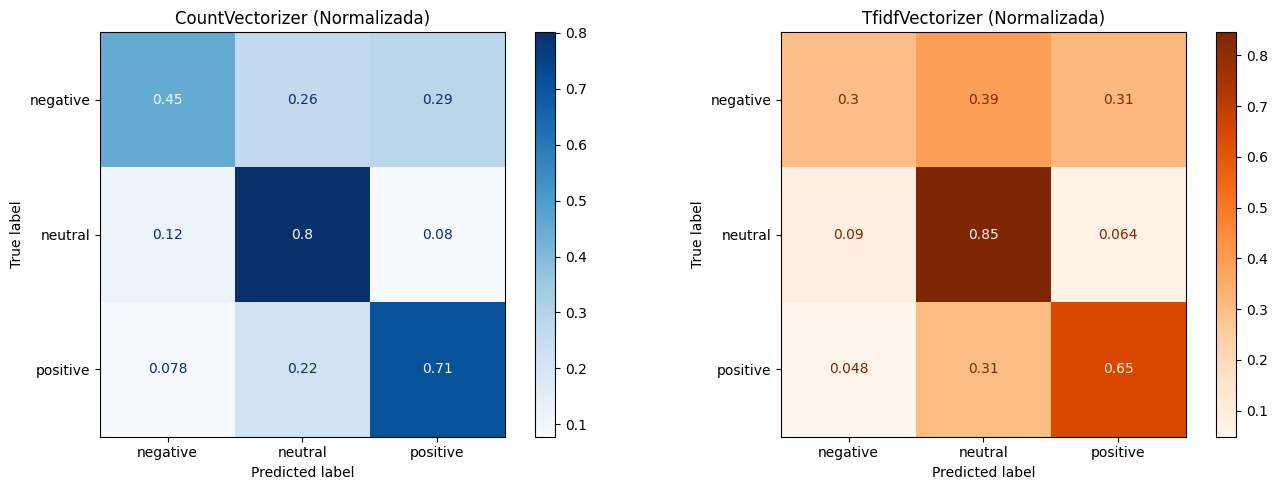


Relatório Detalhado - CountVectorizer:
              precision    recall  f1-score   support

    negative       0.43      0.45      0.44       175
     neutral       0.80      0.80      0.80       622
    positive       0.72      0.71      0.72       372

    accuracy                           0.72      1169
   macro avg       0.65      0.65      0.65      1169
weighted avg       0.72      0.72      0.72      1169


Relatório Detalhado - TfidfVectorizer:
              precision    recall  f1-score   support

    negative       0.41      0.30      0.35       175
     neutral       0.74      0.85      0.79       622
    positive       0.72      0.65      0.68       372

    accuracy                           0.70      1169
   macro avg       0.62      0.60      0.61      1169
weighted avg       0.69      0.70      0.69      1169



In [27]:
# Visualizar matrizes de confusão lado a lado
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# CountVectorizer
disp1 = ConfusionMatrixDisplay.from_estimator(
    model_count, X_test, y_test,
    display_labels=['negative', 'neutral', 'positive'],
    cmap=plt.cm.Blues,
    normalize='true',
    ax=axes[0]
)
disp1.ax_.set_title("CountVectorizer (Normalizada)")

# TfidfVectorizer
disp2 = ConfusionMatrixDisplay.from_estimator(
    model_tfidf, X_test, y_test,
    display_labels=['negative', 'neutral', 'positive'],
    cmap=plt.cm.Oranges,
    normalize='true',
    ax=axes[1]
)
disp2.ax_.set_title("TfidfVectorizer (Normalizada)")

plt.tight_layout()
plt.show()

print("\nRelatório Detalhado - CountVectorizer:")
print(classification_report(y_test, y_pred_count))

print("\nRelatório Detalhado - TfidfVectorizer:")
print(classification_report(y_test, y_pred_tfidf))